#📌 Extracão

In [1]:
import pandas as pd
import json
from json_flattener import flatten

# Carregar o arquivo JSON
with open("api/TelecomX_Data.json", "r") as f:
    data = json.load(f)

# Converter o conteúdo em DataFrame
if isinstance(data, list):
    df = pd.DataFrame(data)
elif isinstance(data, dict):
    for key in data:
        if isinstance(data[key], list):
            df = pd.DataFrame(data[key])
            break
    else:
        df = pd.DataFrame([data])
else:
    raise ValueError("Formato de JSON não suportado.")

# Informações iniciais
print("Dimensões:", df.shape)
print("\nColunas:", df.columns)
print("\nValores ausentes:\n", df.isnull().sum())
print("\nTipos de dados:\n", df.dtypes)
print("\nPrimeiras linhas:\n", df.head())


Dimensões: (7267, 6)

Colunas: Index(['customerID', 'Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')

Valores ausentes:
 customerID    0
Churn         0
customer      0
phone         0
internet      0
account       0
dtype: int64

Tipos de dados:
 customerID    object
Churn         object
customer      object
phone         object
internet      object
account       object
dtype: object

Primeiras linhas:
    customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService'

#🔧 Transformação

In [2]:
def encontrar_colunas(data, caminho="api/TelecomX_Data.json"):
    colunas = set()
    
    if isinstance(data, dict):
        for chave, valor in data.items():
            novo_caminho = f"{caminho}.{chave}" if caminho else chave
            colunas.update(encontrar_colunas(valor, novo_caminho))
    
    elif isinstance(data, list):
        for item in data:
            colunas.update(encontrar_colunas(item, caminho))
    
    else:
        colunas.add(caminho)
    
    return colunas

# Carrega o JSON do arquivo
with open('api/TelecomX_Data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Executa a função e mostra o resultado
colunas_encontradas = encontrar_colunas(data)
print("Colunas aninhadas encontradas:")
for coluna in sorted(colunas_encontradas):
    print("-", coluna)


Colunas aninhadas encontradas:
- api/TelecomX_Data.json.Churn
- api/TelecomX_Data.json.account.Charges.Monthly
- api/TelecomX_Data.json.account.Charges.Total
- api/TelecomX_Data.json.account.Contract
- api/TelecomX_Data.json.account.PaperlessBilling
- api/TelecomX_Data.json.account.PaymentMethod
- api/TelecomX_Data.json.customer.Dependents
- api/TelecomX_Data.json.customer.Partner
- api/TelecomX_Data.json.customer.SeniorCitizen
- api/TelecomX_Data.json.customer.gender
- api/TelecomX_Data.json.customer.tenure
- api/TelecomX_Data.json.customerID
- api/TelecomX_Data.json.internet.DeviceProtection
- api/TelecomX_Data.json.internet.InternetService
- api/TelecomX_Data.json.internet.OnlineBackup
- api/TelecomX_Data.json.internet.OnlineSecurity
- api/TelecomX_Data.json.internet.StreamingMovies
- api/TelecomX_Data.json.internet.StreamingTV
- api/TelecomX_Data.json.internet.TechSupport
- api/TelecomX_Data.json.phone.MultipleLines
- api/TelecomX_Data.json.phone.PhoneService


#📊 Carga e análise

In [3]:
import os
import sqlite3
from typing import Any, List

import pandas as pd
import json


essa_tabela = "telecomx_dados"


def _descobrir_registros(data: Any) -> List[dict]:
    """Descobre a lista de registros dentro do JSON.

    - Se o JSON raiz for uma lista, retorna-a
    - Se o JSON raiz for um dict, tenta encontrar a primeira chave cujo valor seja uma lista de dicts
    - Caso contrário, utiliza o próprio dict como único registro
    """
    if isinstance(data, list):
        return data

    if isinstance(data, dict):
        for valor in data.values():
            if isinstance(valor, list) and any(isinstance(item, dict) for item in valor):
                return valor
        return [data]

    raise ValueError("Formato JSON não suportado para extração de registros.")


def carregar_json_flat_limpo(caminho_arquivo: str) -> pd.DataFrame:
    with open(caminho_arquivo, "r") as f:
        data = json.load(f)

    registros = _descobrir_registros(data)

    # Flatten automático dos objetos aninhados
    df = pd.json_normalize(registros, sep=".")

    # Remover colunas totalmente nulas ou com valores vazios
    if not df.empty:
        df = df.dropna(axis=1, how="all")
        colunas_nao_vazias: List[str] = []
        for coluna in df.columns:
            serie = df[coluna]
            todos_vazios = serie.apply(
                lambda x: (x is None) or (isinstance(x, str) and x.strip() == "") or pd.isna(x)
            ).all()
            if not todos_vazios:
                colunas_nao_vazias.append(coluna)
        df = df[colunas_nao_vazias]

    return df


def criar_e_inserir_sqlite(
    df: pd.DataFrame,
    nome_db: str = "api/telecomx.db",
    nome_tabela: str = essa_tabela,
    recriar_tabela: bool = True,
) -> None:
    conn = sqlite3.connect(nome_db)
    cursor = conn.cursor()

    colunas = list(df.columns)

    if recriar_tabela:
        cursor.execute(f"DROP TABLE IF EXISTS {nome_tabela}")

    colunas_sql = ", ".join([f'"{col}" TEXT' for col in colunas])

    sql_criar = f"""
    CREATE TABLE IF NOT EXISTS {nome_tabela} (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        {colunas_sql}
    );
    """
    cursor.execute(sql_criar)

    if not df.empty:
        placeholders = ", ".join(["?"] * len(colunas))
        colunas_formatadas = ", ".join([f'"{col}"' for col in colunas])
        sql_insert = f"INSERT INTO {nome_tabela} ({colunas_formatadas}) VALUES ({placeholders})"
        valores = [
            tuple(None if pd.isna(v) else str(v) for v in row)
            for _, row in df[colunas].iterrows()
        ]
        cursor.executemany(sql_insert, valores)

    conn.commit()
    conn.close()
    print(f"DADOS INSERIDOS no banco '{nome_db}' na tabela '{nome_tabela}'.")


def _detectar_caminho_json() -> str:
    candidatos = [
        "api/TelecomX_data.json",  # grafia 1
        "api/TelecomX_Data.json",  # grafia 2 (original no repo)
    ]
    for caminho in candidatos:
        if os.path.exists(caminho):
            return caminho
    raise FileNotFoundError(
        "Arquivo JSON não encontrado. Procure por 'api/TelecomX_data.json' ou 'api/TelecomX_Data.json'."
    )


# Execução da Carga e Análise básica
caminho_arquivo_json = _detectar_caminho_json()

df_limpo = carregar_json_flat_limpo(caminho_arquivo_json)
print("DataFrame gerado:")
print(df_limpo.head())
print("\nDimensões:", df_limpo.shape)
print("\nColunas:", df_limpo.columns.tolist())

criar_e_inserir_sqlite(df_limpo)


DataFrame gerado:
   customerID Churn customer.gender  customer.SeniorCitizen customer.Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer.Dependents  customer.tenure phone.PhoneService phone.MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes                  No   

  internet.Int

#📄Relatorio Final

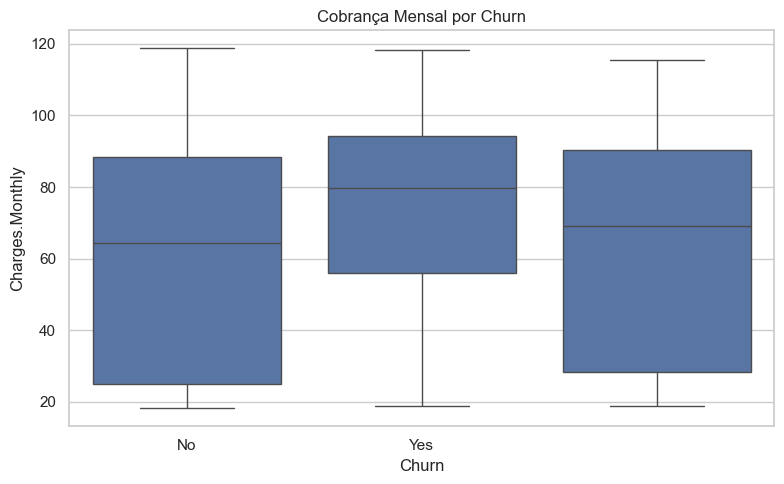

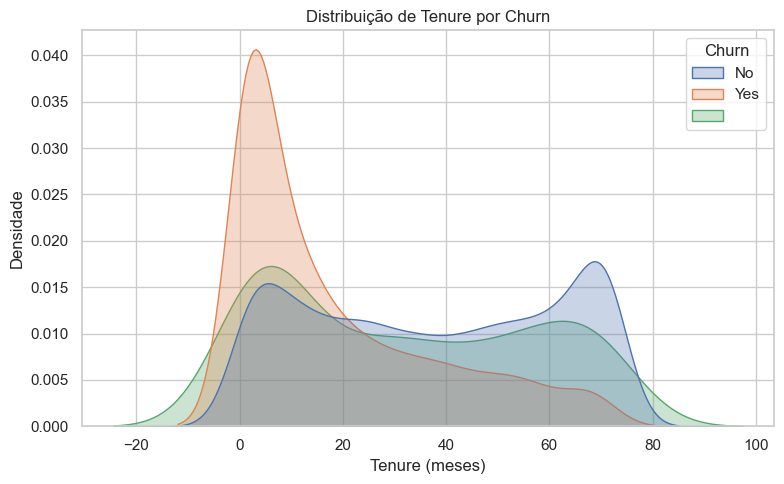

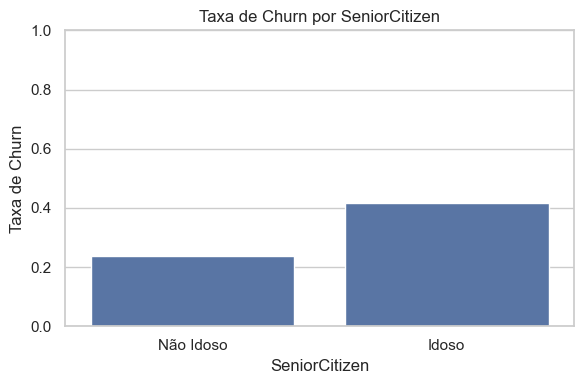

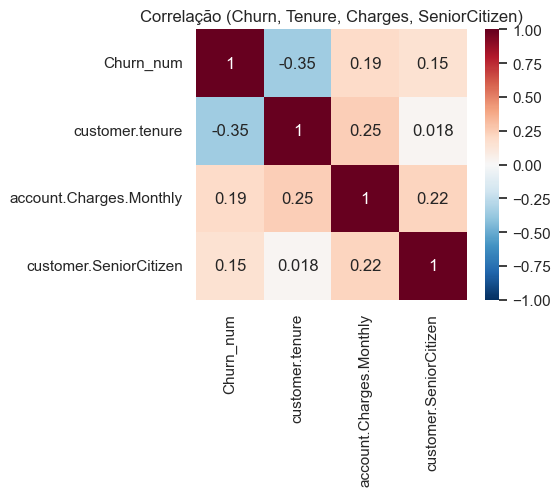


Conclusões:
- Menor tenure está associado a maior churn (correlação negativa).
- Cobrança mensal mais alta apresenta maior churn (correlação positiva).
- Clientes idosos mostram maior taxa média de churn.


In [5]:
# 📄 Relatório Final (Gráficos)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Garantir que o DataFrame de análise exista
if 'df_limpo' not in globals():
    raise RuntimeError("df_limpo não encontrado. Execute a célula de Carga e análise antes.")

# Cópia de trabalho
_df = df_limpo.copy()

# Conversões e colunas auxiliares
_df['customer.tenure'] = pd.to_numeric(_df.get('customer.tenure'), errors='coerce')
_df['account.Charges.Monthly'] = pd.to_numeric(_df.get('account.Charges.Monthly'), errors='coerce')
_df['customer.SeniorCitizen'] = pd.to_numeric(_df.get('customer.SeniorCitizen'), errors='coerce')
_df['Churn_num'] = _df['Churn'].map({'Yes': 1, 'No': 0})

sns.set(style='whitegrid', context='notebook')

# 1) Cobrança mensal por Churn
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=_df,
    x='Churn', y='account.Charges.Monthly',
    showfliers=False
)
plt.title('Cobrança Mensal por Churn')
plt.xlabel('Churn')
plt.ylabel('Charges.Monthly')
plt.tight_layout()
plt.show()

# 2) Distribuição do Tenure por Churn
plt.figure(figsize=(8, 5))
sns.kdeplot(
    data=_df.dropna(subset=['customer.tenure']),
    x='customer.tenure', hue='Churn',
    common_norm=False, fill=True, alpha=0.3
)
plt.title('Distribuição de Tenure por Churn')
plt.xlabel('Tenure (meses)')
plt.ylabel('Densidade')
plt.tight_layout()
plt.show()

# 3) Taxa de churn por indicador SeniorCitizen
rate = (
    _df.dropna(subset=['customer.SeniorCitizen'])
       .groupby('customer.SeniorCitizen', as_index=False)['Churn_num']
       .mean()
       .rename(columns={'Churn_num': 'churn_rate'})
)
rate['customer.SeniorCitizen'] = rate['customer.SeniorCitizen'].map({0: 'Não Idoso', 1: 'Idoso'}).fillna('N/D')

plt.figure(figsize=(6, 4))
sns.barplot(data=rate, x='customer.SeniorCitizen', y='churn_rate')
plt.title('Taxa de Churn por SeniorCitizen')
plt.xlabel('SeniorCitizen')
plt.ylabel('Taxa de Churn')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# 4) Mapa de calor de correlação
cols = ['Churn_num', 'customer.tenure', 'account.Charges.Monthly', 'customer.SeniorCitizen']
mat = _df[cols].copy()

corr = mat.corr(numeric_only=True)
plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap='RdBu_r', vmin=-1, vmax=1, square=True)
plt.title('Correlação (Churn, Tenure, Charges, SeniorCitizen)')
plt.tight_layout()
plt.show()

# Observações finais
print('\nConclusões:')
print('- Menor tenure está associado a maior churn (correlação negativa).')
print('- Cobrança mensal mais alta apresenta maior churn (correlação positiva).')
print('- Clientes idosos mostram maior taxa média de churn.')
